ARから作ったデータでやる

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+20]
# No = (os.path.basename(__file__))[-4]
No = "0_1" # notebook用
# print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path)
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models
# p-Wasserstein距離の関数
import Wasserstein

In [2]:
phi_a = [1.0, -0.5, 0.7, -0.4]
phi_b = [0]
p = len(phi_a)
q = len(phi_b)
dataSeed=5
N = 1000
data = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal')
inno = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal', return_innovation=True)

### 非線形ARで同じARMAモデル時系列を推定してちゃんとmseが下がるかどうか
を確認する

まずは、AR(p)を仮定したモデリングを行う。つまり、中間層は一次元。最初はAIC最小と言われた$\hat p=6$でやる

In [3]:
hat_p = 6
hat_q = 0

In [4]:
# 学習する推定モデルの形状や学習方法なんかを決定します
# 学習時のハイパラの決定（入力を受け付ける）
parser = argparse.ArgumentParser()
parser.add_argument("--generator_seed", type=int, default=0, help="generatorのパラメータの初期値のシード")
parser.add_argument("--predictor_seed", type=int, default=0, help="predictorのパラメータの初期値のシード")
parser.add_argument("--batch_size", type=int, default=64, help="batchの大きさ")
parser.add_argument("--training_seed", type=int, default=0, help="訓練データを学習させる順番を決めるシード")
parser.add_argument("--n_epochs", type=int, default=2000, help="学習させる回数")

opt = parser.parse_args(args=[]) # .ipynbの場合はこちらを使用

opt.batch_size=128

In [5]:
os.makedirs("output-images/p{0}".format(hat_p), exist_ok=True)
os.makedirs("parameters/p{0}".format(hat_p), exist_ok=True)

In [6]:
import checkGPU
cuda, device = checkGPU.checkGPU()

GPUは使えません。


In [7]:
import models
torch.manual_seed(opt.generator_seed)
generator = models.Generator(p = p, q=q)

In [8]:
a= torch.rand([opt.batch_size,1,p+1])# 最初はバッチサイズ
print("input size   :",a.shape)
b = generator(a)
print("output size:",b.shape)

input size   : torch.Size([128, 1, 5])
output size: torch.Size([128, 2])


In [9]:
class predictNet(nn.Module):
    def __init__(self, p=7, n_unit1=16, n_unit2=16):
        super(predictNet, self).__init__()
        
        self.fc1 = nn.Linear(p+1, n_unit1)
        self.fc2 = nn.Linear(n_unit1, n_unit2)
        self.fc3 = nn.Linear(n_unit2,1)
        
    def forward(self,x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x

In [10]:
torch.manual_seed(opt.predictor_seed)
predictor = predictNet(p=hat_p)

In [11]:
a= torch.rand([opt.batch_size, hat_p+1])# 最初はバッチサイズ
print("input size   :",a.shape)
b = predictor(a)
print("output size:",b.shape)

input size   : torch.Size([128, 7])
output size: torch.Size([128, 1])


In [12]:
Data = data.copy()
Data = torch.tensor(Data, dtype=torch.float)
Data=Data.view(1,-1) # 一次元の時系列ならこれで。
trainData = Data[:,:900]
valData = Data[:,900:]

In [13]:
optimizer_G = torch.optim.Adam(params=generator.parameters(), lr=0.0001 )
optimizer_F = torch.optim.Adam(params=predictor.parameters(), lr=0.0001 )
# optimizer_F = torch.optim.RMSprop(params=predictor.parameters())

In [14]:
mseLoss = nn.MSELoss()

In [15]:
# パラメータと学習データをGPUに乗っける
generator.to(device)
predictor.to(device)
trainData = trainData.to(device)
valData = valData.to(device)
mseLoss = mseLoss.to(device)

In [16]:
# 学習方法の決定？

In [17]:
def make_XY(x:np.ndarray, p:int):
    x = torch.tensor(x, dtype=torch.float)
    X = [x[i:i+p] for i in range(len(x)-p)]
    Y = [x[i+p] for i in range(len(x)-p)]
    return X, Y

In [18]:
class DataSet:
    def __init__(self, tsData, hat_p):
        """
        tsData：時系列データ（今回は一次元の時系列を想定）
        hat_p　：想定する次数
        initで入力データと出力データを作成する。
        """
        self.tsData =  torch.tensor(tsData, dtype=torch.float) # torch.tensorに変換
        self.hat_p = hat_p
        self.X, self.Y = make_XY(self.tsData, self.hat_p)
    
    def  __len__(self):
        return len(self.X) # データ数を返す
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [19]:
dataset = DataSet(data, hat_p=hat_p)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=True, drop_last=True)# dataloaderをiterで回すと、毎回入力と出力のペアがlistでくる

In [20]:
# class withoutDiscriminator:
#     """
#     提案手法
#     """
#     def __init__(self, tsData, hat_p):
#         self.X = 
#         pass
    
#     def fit(self):
#         pass
    
#     def predict(self, x):
#         pass

epoch：1/1000   loss_F： 3.7310   経過時間： 0.0秒
epoch：2/1000   loss_F： 3.6668   経過時間： 0.0秒
epoch：3/1000   loss_F： 3.7811   経過時間： 0.1秒
epoch：4/1000   loss_F： 3.6142   経過時間： 0.1秒
epoch：5/1000   loss_F： 3.7277   経過時間： 0.1秒
epoch：6/1000   loss_F： 3.7302   経過時間： 0.1秒
epoch：7/1000   loss_F： 3.7784   経過時間： 0.2秒
epoch：8/1000   loss_F： 3.7727   経過時間： 0.2秒
epoch：9/1000   loss_F： 3.7283   経過時間： 0.2秒
epoch：10/1000   loss_F： 3.7112   経過時間： 0.2秒
epoch：11/1000   loss_F： 3.8035   経過時間： 0.2秒
epoch：12/1000   loss_F： 3.6263   経過時間： 0.3秒
epoch：13/1000   loss_F： 3.7728   経過時間： 0.3秒
epoch：14/1000   loss_F： 3.7321   経過時間： 0.3秒
epoch：15/1000   loss_F： 3.7495   経過時間： 0.3秒
epoch：16/1000   loss_F： 3.7029   経過時間： 0.3秒
epoch：17/1000   loss_F： 3.7090   経過時間： 0.4秒
epoch：18/1000   loss_F： 3.6999   経過時間： 0.4秒
epoch：19/1000   loss_F： 3.7676   経過時間： 0.4秒
epoch：20/1000   loss_F： 3.7290   経過時間： 0.4秒
epoch：21/1000   loss_F： 3.6926   経過時間： 0.5秒
epoch：22/1000   loss_F： 3.6825   経過時間： 0.5秒
epoch：23/1000   loss_F： 3.6317   経過時間： 0.

epoch：188/1000   loss_F： 3.6812   経過時間： 3.9秒
epoch：189/1000   loss_F： 3.7245   経過時間： 3.9秒
epoch：190/1000   loss_F： 3.5497   経過時間： 3.9秒
epoch：191/1000   loss_F： 3.6525   経過時間： 4.0秒
epoch：192/1000   loss_F： 3.6695   経過時間： 4.0秒
epoch：193/1000   loss_F： 3.6505   経過時間： 4.0秒
epoch：194/1000   loss_F： 3.7716   経過時間： 4.0秒
epoch：195/1000   loss_F： 3.6986   経過時間： 4.1秒
epoch：196/1000   loss_F： 3.6975   経過時間： 4.1秒
epoch：197/1000   loss_F： 3.7368   経過時間： 4.1秒
epoch：198/1000   loss_F： 3.6997   経過時間： 4.1秒
epoch：199/1000   loss_F： 3.6946   経過時間： 4.1秒
epoch：200/1000   loss_F： 3.5852   経過時間： 4.2秒
epoch：201/1000   loss_F： 3.7183   経過時間： 4.2秒
epoch：202/1000   loss_F： 3.6990   経過時間： 4.2秒
epoch：203/1000   loss_F： 3.7187   経過時間： 4.2秒
epoch：204/1000   loss_F： 3.7276   経過時間： 4.2秒
epoch：205/1000   loss_F： 3.7592   経過時間： 4.3秒
epoch：206/1000   loss_F： 3.6647   経過時間： 4.3秒
epoch：207/1000   loss_F： 3.6823   経過時間： 4.3秒
epoch：208/1000   loss_F： 3.7475   経過時間： 4.3秒
epoch：209/1000   loss_F： 3.7158   経過時間： 4.4秒
epoch：210/

epoch：373/1000   loss_F： 3.7060   経過時間： 7.8秒
epoch：374/1000   loss_F： 3.7139   経過時間： 7.8秒
epoch：375/1000   loss_F： 3.6309   経過時間： 7.8秒
epoch：376/1000   loss_F： 3.6675   経過時間： 7.8秒
epoch：377/1000   loss_F： 3.7265   経過時間： 7.8秒
epoch：378/1000   loss_F： 3.7269   経過時間： 7.9秒
epoch：379/1000   loss_F： 3.7300   経過時間： 7.9秒
epoch：380/1000   loss_F： 3.7302   経過時間： 7.9秒
epoch：381/1000   loss_F： 3.7665   経過時間： 7.9秒
epoch：382/1000   loss_F： 3.6712   経過時間： 7.9秒
epoch：383/1000   loss_F： 3.7141   経過時間： 8.0秒
epoch：384/1000   loss_F： 3.6979   経過時間： 8.0秒
epoch：385/1000   loss_F： 3.7752   経過時間： 8.0秒
epoch：386/1000   loss_F： 3.6819   経過時間： 8.0秒
epoch：387/1000   loss_F： 3.6676   経過時間： 8.0秒
epoch：388/1000   loss_F： 3.6750   経過時間： 8.1秒
epoch：389/1000   loss_F： 3.7003   経過時間： 8.1秒
epoch：390/1000   loss_F： 3.8172   経過時間： 8.1秒
epoch：391/1000   loss_F： 3.5467   経過時間： 8.1秒
epoch：392/1000   loss_F： 3.7546   経過時間： 8.1秒
epoch：393/1000   loss_F： 3.7584   経過時間： 8.2秒
epoch：394/1000   loss_F： 3.8064   経過時間： 8.2秒
epoch：395/

epoch：555/1000   loss_F： 3.7561   経過時間： 11.5秒
epoch：556/1000   loss_F： 3.6793   経過時間： 11.5秒
epoch：557/1000   loss_F： 3.4935   経過時間： 11.6秒
epoch：558/1000   loss_F： 3.7031   経過時間： 11.6秒
epoch：559/1000   loss_F： 3.5753   経過時間： 11.6秒
epoch：560/1000   loss_F： 3.7184   経過時間： 11.6秒
epoch：561/1000   loss_F： 3.7630   経過時間： 11.6秒
epoch：562/1000   loss_F： 3.6998   経過時間： 11.7秒
epoch：563/1000   loss_F： 3.6686   経過時間： 11.7秒
epoch：564/1000   loss_F： 3.5638   経過時間： 11.7秒
epoch：565/1000   loss_F： 3.6726   経過時間： 11.7秒
epoch：566/1000   loss_F： 3.7409   経過時間： 11.7秒
epoch：567/1000   loss_F： 3.6739   経過時間： 11.8秒
epoch：568/1000   loss_F： 3.7697   経過時間： 11.8秒
epoch：569/1000   loss_F： 3.5622   経過時間： 11.8秒
epoch：570/1000   loss_F： 3.6639   経過時間： 11.8秒
epoch：571/1000   loss_F： 3.6381   経過時間： 11.8秒
epoch：572/1000   loss_F： 3.7000   経過時間： 11.9秒
epoch：573/1000   loss_F： 3.6763   経過時間： 11.9秒
epoch：574/1000   loss_F： 3.7173   経過時間： 11.9秒
epoch：575/1000   loss_F： 3.6269   経過時間： 11.9秒
epoch：576/1000   loss_F： 3.7644   

epoch：739/1000   loss_F： 3.7012   経過時間： 15.3秒
epoch：740/1000   loss_F： 3.6356   経過時間： 15.4秒
epoch：741/1000   loss_F： 3.6512   経過時間： 15.4秒
epoch：742/1000   loss_F： 3.7285   経過時間： 15.4秒
epoch：743/1000   loss_F： 3.6269   経過時間： 15.4秒
epoch：744/1000   loss_F： 3.7227   経過時間： 15.4秒
epoch：745/1000   loss_F： 3.7803   経過時間： 15.5秒
epoch：746/1000   loss_F： 3.6599   経過時間： 15.5秒
epoch：747/1000   loss_F： 3.7010   経過時間： 15.5秒
epoch：748/1000   loss_F： 3.6288   経過時間： 15.5秒
epoch：749/1000   loss_F： 3.7432   経過時間： 15.5秒
epoch：750/1000   loss_F： 3.6382   経過時間： 15.6秒
epoch：751/1000   loss_F： 3.7040   経過時間： 15.6秒
epoch：752/1000   loss_F： 3.7199   経過時間： 15.6秒
epoch：753/1000   loss_F： 3.6364   経過時間： 15.6秒
epoch：754/1000   loss_F： 3.6713   経過時間： 15.7秒
epoch：755/1000   loss_F： 3.6976   経過時間： 15.7秒
epoch：756/1000   loss_F： 3.6563   経過時間： 15.7秒
epoch：757/1000   loss_F： 3.5755   経過時間： 15.7秒
epoch：758/1000   loss_F： 3.7118   経過時間： 15.7秒
epoch：759/1000   loss_F： 3.6098   経過時間： 15.8秒
epoch：760/1000   loss_F： 3.7372   

epoch：922/1000   loss_F： 3.5938   経過時間： 19.2秒
epoch：923/1000   loss_F： 3.6553   経過時間： 19.2秒
epoch：924/1000   loss_F： 3.7308   経過時間： 19.2秒
epoch：925/1000   loss_F： 3.5492   経過時間： 19.2秒
epoch：926/1000   loss_F： 3.7170   経過時間： 19.2秒
epoch：927/1000   loss_F： 3.6550   経過時間： 19.3秒
epoch：928/1000   loss_F： 3.7440   経過時間： 19.3秒
epoch：929/1000   loss_F： 3.7046   経過時間： 19.3秒
epoch：930/1000   loss_F： 3.6558   経過時間： 19.3秒
epoch：931/1000   loss_F： 3.7002   経過時間： 19.3秒
epoch：932/1000   loss_F： 3.7070   経過時間： 19.4秒
epoch：933/1000   loss_F： 3.6749   経過時間： 19.4秒
epoch：934/1000   loss_F： 3.6924   経過時間： 19.4秒
epoch：935/1000   loss_F： 3.6455   経過時間： 19.4秒
epoch：936/1000   loss_F： 3.7644   経過時間： 19.4秒
epoch：937/1000   loss_F： 3.8151   経過時間： 19.5秒
epoch：938/1000   loss_F： 3.6319   経過時間： 19.5秒
epoch：939/1000   loss_F： 3.6982   経過時間： 19.5秒
epoch：940/1000   loss_F： 3.6557   経過時間： 19.5秒
epoch：941/1000   loss_F： 3.5807   経過時間： 19.5秒
epoch：942/1000   loss_F： 3.6652   経過時間： 19.6秒
epoch：943/1000   loss_F： 3.7151   

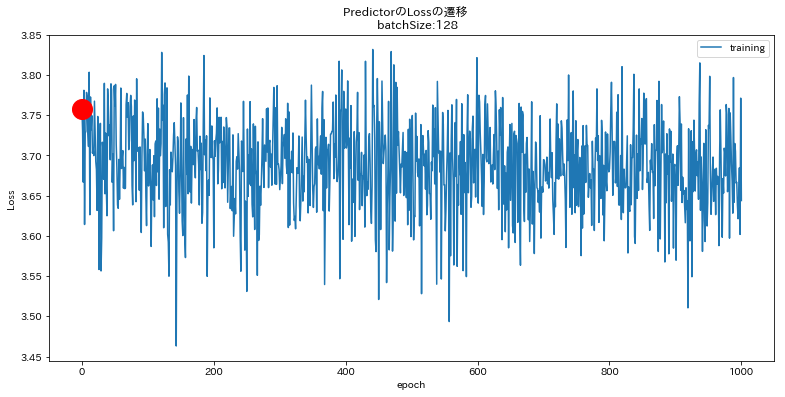

In [21]:
# 学習データの使い方のシードを決定
random.seed(a=opt.training_seed)

# ---------
# Fのpretrain
# ---------
n_epoch_pre = 1000
loss_F_pre = []
# Lossの遷移の履歴に学習前の状態のLossを加える
a=0
for X, Y in dataloader:
    input_tensor = torch.cat([torch.zeros([opt.batch_size,1]).to(device), X], axis=1)
    a+=(mseLoss(predictor(input_tensor), Y)).item()
loss_F_pre.append(a/len(dataloader))


    
    
pretrain_param = 'parameters/p{0}/No{1}_predictor_epoch{2}_batchSize{3}_DataSeed{4}.pth'.format(hat_p, No, 0, opt.batch_size, dataSeed )

start=time.time()

for epoch in range(n_epoch_pre):
    epoch_loss = 0
    for X, Y in dataloader:
        input_tensor = torch.cat([torch.randn([opt.batch_size,1]).to(device), X], axis=1)# ランダムな次元を追加
        optimizer_F.zero_grad()
        loss_F = mseLoss(predictor(input_tensor), Y)
        loss_F.backward()
        optimizer_F.step()
        epoch_loss += loss_F.item()
    loss_F_pre.append(epoch_loss/len(dataloader))
    print("epoch：{0}/{1}   loss_F：{2: .4f}   経過時間：{3: .1f}秒".format(epoch+1, n_epoch_pre, round(loss_F_pre[-1], 4), time.time()-start))

torch.save(predictor.state_dict(), pretrain_param)

plt.figure(figsize=(13,6))
plt.title("PredictorのLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(loss_F_pre, label="training")
plt.plot(0,loss_F_pre[0], marker='o', markersize=20, color="red")
plt.legend()
plt.savefig("output-images/p{0}/No{1}_preloss_batchSize{3}_DataSeed{4}.png".format(hat_p, No, epoch, opt.batch_size, dataSeed ))
# plt.close()

### 学習できてるのか確かめる

#### 学習前のpredictorと学習後のpredictorのtestLossを比較する

In [22]:
testData = tsModel.ARIMA(a=phi_a, b=phi_b, N=1000, random_seed=2**32-1, randomness='normal')
testdataset = DataSet(testData, hat_p=hat_p)
testdataloader = torch.utils.data.DataLoader(testdataset, batch_size=opt.batch_size, shuffle=True, drop_last=True)

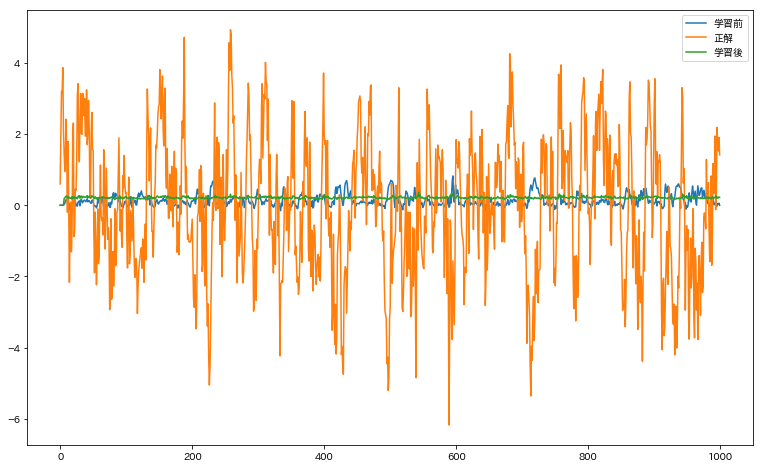

In [23]:
torch.manual_seed(opt.predictor_seed)
predictor = predictNet(p=hat_p)

pred = []
for i in range(1000):
    if i < 6:
        pred.append(0)
    else:
        ret = torch.cat([torch.zeros(1,1), torch.tensor(testData[i-hat_p:i], dtype=torch.float).view(1,-1)], axis = 1)
        ret = predictor(ret)
        pred.append(ret.item())
    
plt.figure(figsize=(13,8))
plt.plot(pred, label="学習前")
plt.plot(testData, label = "正解")

predictor.load_state_dict(torch.load(pretrain_param)) 
pred = []
for i in range(1000):
    if i < 6:
        pred.append(0)
    else:
        ret = torch.cat([torch.zeros(1,1), torch.tensor(testData[i-hat_p:i], dtype=torch.float).view(1,-1)], axis = 1)
        ret = predictor(ret)
        pred.append(ret.item())
plt.plot(pred, label="学習後")
plt.legend()

学習してない

#### 偶数と奇数を当てる問題で、コードのミスかどうかを調べる